In [31]:
'''1. Piece-Wise Linear Transformation (Contrast Stretching and Clipping):'''

'1. Piece-Wise Linear Transformation (Contrast Stretching and Clipping):'

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def contrast_stretching(image, r1, s1, r2, s2):

    def transform_pixel(p):
        if p < r1:
            return (s1 / r1) * p
        elif p < r2:
            return s1 + ((s2 - s1) / (r2 - r1)) * (p - r1)
        else:
            return s2 + ((255 - s2) / (255 - r2)) * (p - r2)

    transform = np.vectorize(transform_pixel)
    return transform(image).astype(np.uint8)


def intensity_clipping(image, min_val, max_val):
    clipped = np.clip(image, min_val, max_val)
    return ((clipped - min_val) / (max_val - min_val) * 255).astype(np.uint8)

def plot_histogram(image, title):
    plt.hist(image.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()


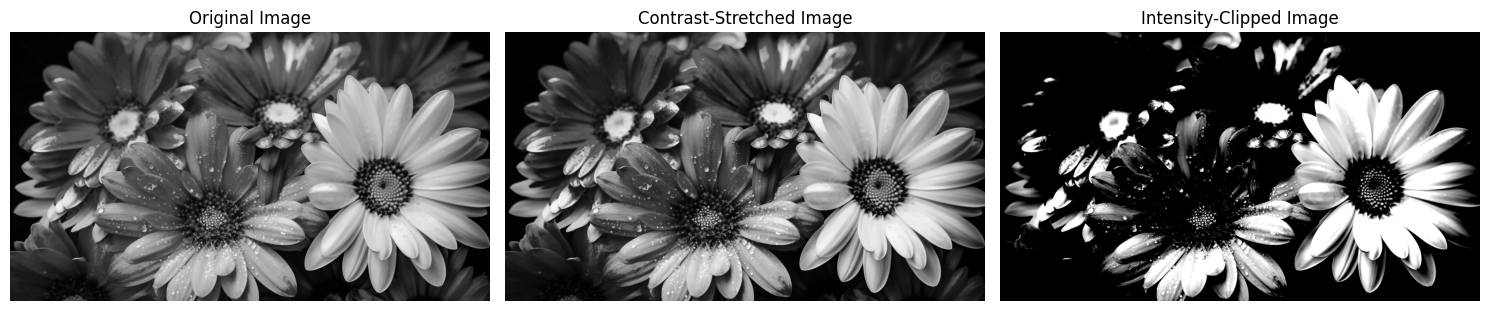

In [33]:
image = cv2.imread(r'/home/student/Downloads/image.jpg', cv2.IMREAD_GRAYSCALE)

r1, s1, r2, s2 = 50, 30, 200, 220
contrast_stretched = contrast_stretching(image, r1, s1, r2, s2)

min_val, max_val = 100, 180
clipped_image = intensity_clipping(image, min_val, max_val)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(contrast_stretched, cmap='gray')
plt.title('Contrast-Stretched Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(clipped_image, cmap='gray')
plt.title('Intensity-Clipped Image')
plt.axis('off')

plt.tight_layout()
plt.show()


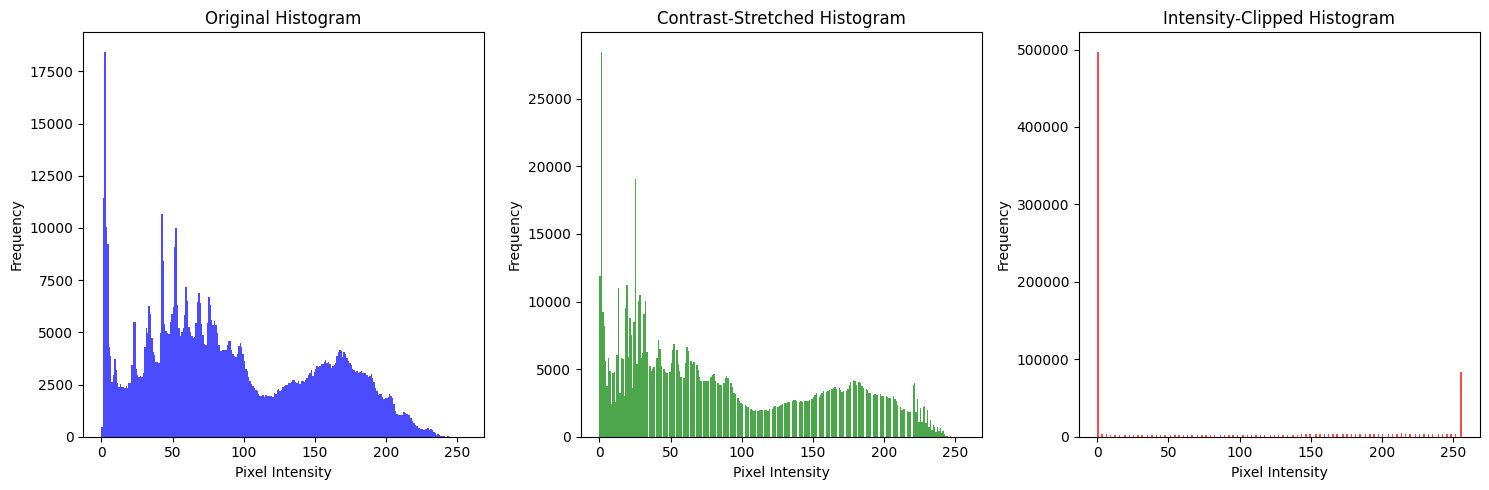

In [34]:
plt.figure(figsize=(15, 5))

# Original histogram
plt.subplot(1, 3, 1)
plt.hist(image.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
plt.title('Original Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Contrast-stretched histogram
plt.subplot(1, 3, 2)
plt.hist(contrast_stretched.ravel(), bins=256, range=(0, 256), color='green', alpha=0.7)
plt.title('Contrast-Stretched Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Intensity-clipped histogram
plt.subplot(1, 3, 3)
plt.hist(clipped_image.ravel(), bins=256, range=(0, 256), color='red', alpha=0.7)
plt.title('Intensity-Clipped Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [35]:
'''2. Enhanced Bit-Plane Fusion with Custom Weighting:'''

'2. Enhanced Bit-Plane Fusion with Custom Weighting:'

In [36]:
from skimage.metrics import structural_similarity as ssim

def extract_bit_planes(image):
    bit_planes = []
    for i in range(8):
        bit_planes.append((image & (1 << i)) >> i)
    return bit_planes

def reconstruct_image(bit_planes, weights):
    reconstructed = np.zeros_like(bit_planes[0], dtype=np.float32)
    for i in range(8):
        reconstructed += weights[i] * bit_planes[i]
    return np.clip(reconstructed * 255, 0, 255).astype(np.uint8)

def compute_metrics(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    psnr = 10 * np.log10(255**2 / mse) if mse != 0 else float('inf')
    ssim_value = ssim(original, reconstructed, data_range=255)
    return mse, psnr, ssim_value



In [37]:
image = cv2.imread( r'/home/student/Downloads/image3.jpg', cv2.IMREAD_GRAYSCALE)


bit_planes = extract_bit_planes(image)


weights1 = [0.5, 0.3, 0.1, 0.05, 0.03, 0.02, 0.01, 0.005]
weights2 = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.02]


reconstructed1 = reconstruct_image(bit_planes, weights1)
reconstructed2 = reconstruct_image(bit_planes, weights2)

mse1, psnr1, ssim1 = compute_metrics(image, reconstructed1)
mse2, psnr2, ssim2 = compute_metrics(image, reconstructed2)



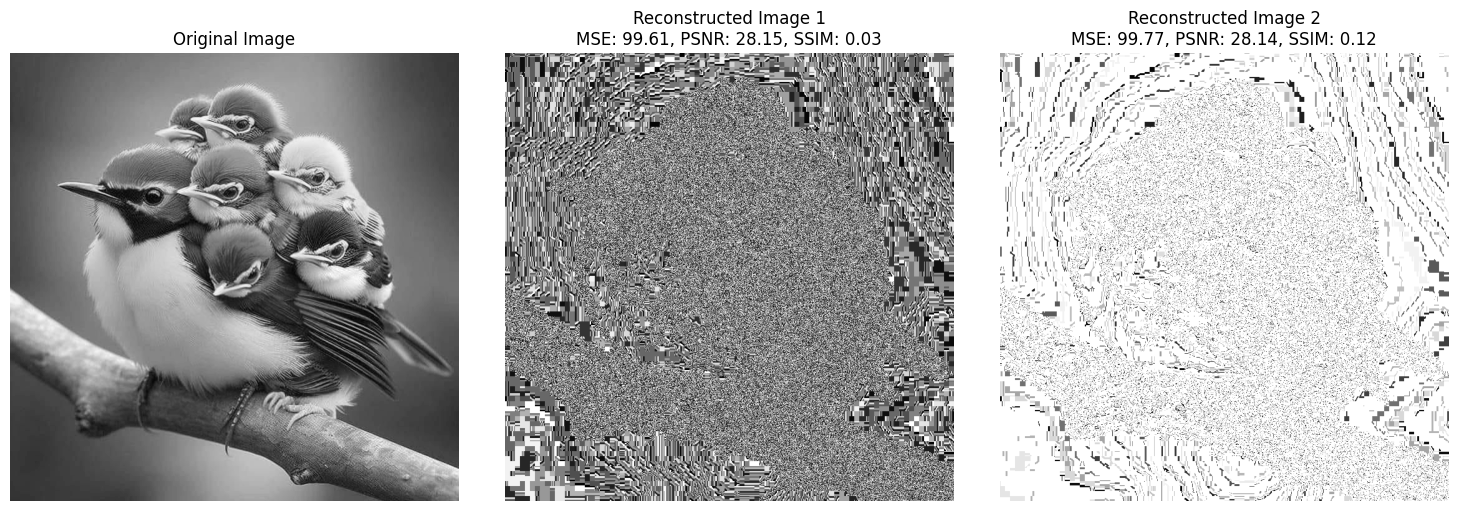

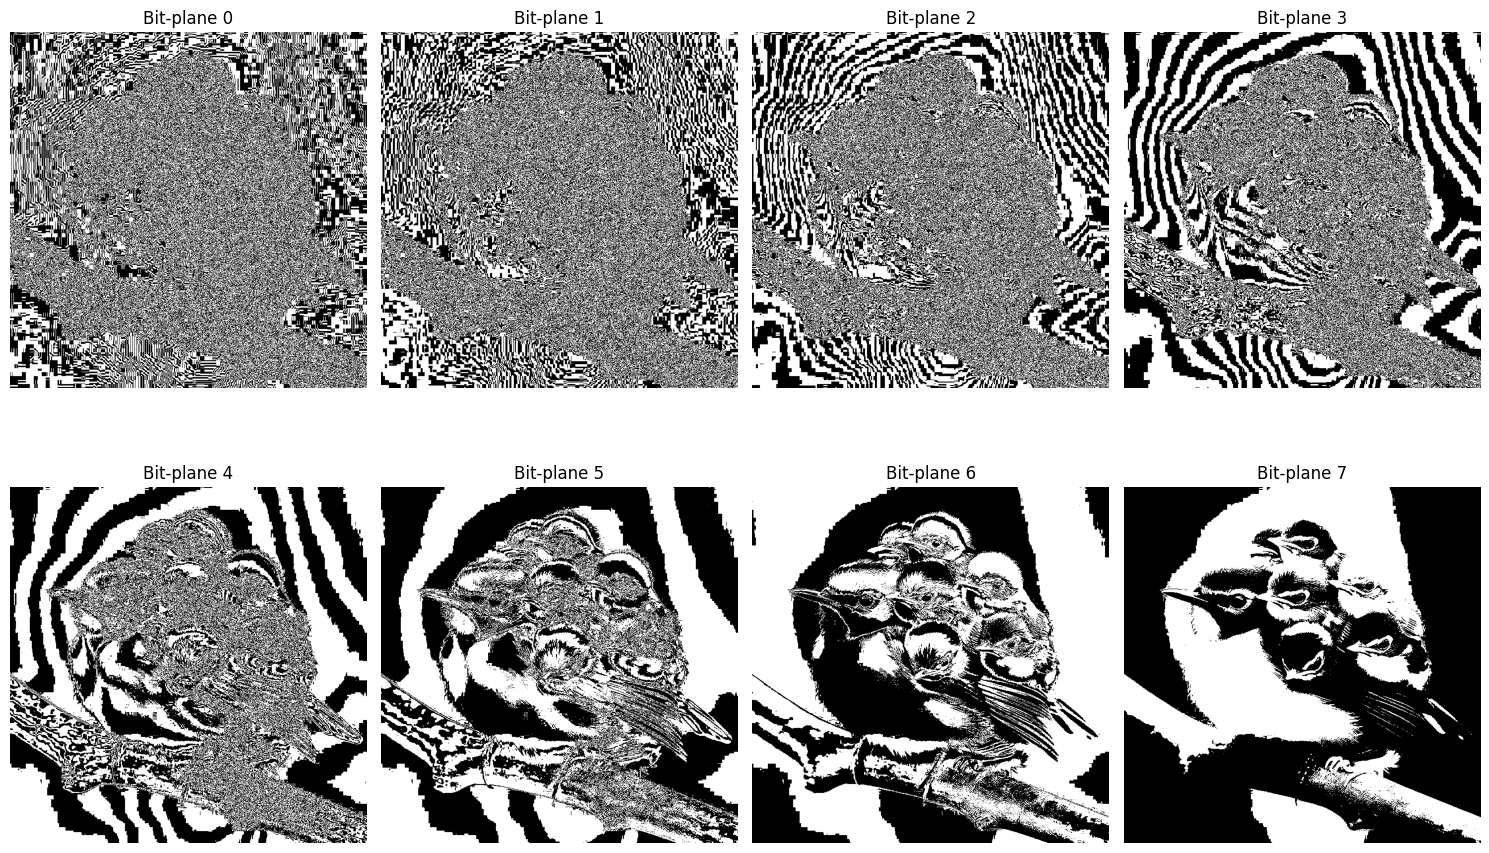

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed1, cmap='gray')
plt.title(f'Reconstructed Image 1\nMSE: {mse1:.2f}, PSNR: {psnr1:.2f}, SSIM: {ssim1:.2f}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed2, cmap='gray')
plt.title(f'Reconstructed Image 2\nMSE: {mse2:.2f}, PSNR: {psnr2:.2f}, SSIM: {ssim2:.2f}')
plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize bit-planes
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(bit_planes[i] * 255, cmap='gray')
    plt.title(f'Bit-plane {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [39]:

def divide_image(image, grid_size, overlap_ratio):
    h, w = image.shape
    step_h = int(h / grid_size[0] * (1 - overlap_ratio))
    step_w = int(w / grid_size[1] * (1 - overlap_ratio))
    regions = []
    for i in range(0, h, step_h):
        for j in range(0, w, step_w):
            region = image[i:i + step_h * 2, j:j + step_w * 2]  
            regions.append(((i, j), region))
    return regions



In [40]:

def apply_histogram_shift(region, shift_value):
    shifted = region + shift_value
    shifted = np.clip(shifted, 0, 255) 
    return shifted


def blend_regions(regions, image_shape, grid_size, overlap_ratio):
    blended = np.zeros(image_shape, dtype=np.float32)
    count = np.zeros(image_shape, dtype=np.float32)
    
    step_h = int(image_shape[0] / grid_size[0] * (1 - overlap_ratio))
    step_w = int(image_shape[1] / grid_size[1] * (1 - overlap_ratio))
    
    for (i, j), region in regions:
        region_h, region_w = region.shape
        blended[i:i + region_h, j:j + region_w] += region
        count[i:i + region_h, j:j + region_w] += 1
    
    return np.clip(blended / count, 0, 255).astype(np.uint8)

def plot_histogram(image, title):
    plt.hist(image.ravel(), bins=256, range=(0, 255), color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()



In [41]:
'''3. Multi-Level Histogram Shifting with Overlap Zones:'''

'3. Multi-Level Histogram Shifting with Overlap Zones:'

In [42]:
image = cv2.imread(r'/home/student/Downloads/image4.jpg', cv2.IMREAD_GRAYSCALE)

grid_size = (3, 3) 
overlap_ratio = 0.5
shifts = [+60, -40, +20]
random_shift_range = (-50, 50)

regions = divide_image(image, grid_size, overlap_ratio)

shifted_regions = []
for idx, ((i, j), region) in enumerate(regions):
    if idx < len(shifts):  
        shift_value = shifts[idx]
    else:  
        shift_value = np.random.randint(random_shift_range[0], random_shift_range[1])
    shifted_region = apply_histogram_shift(region, shift_value)
    shifted_regions.append(((i, j), shifted_region))

modified_image = blend_regions(shifted_regions, image.shape, grid_size, overlap_ratio)



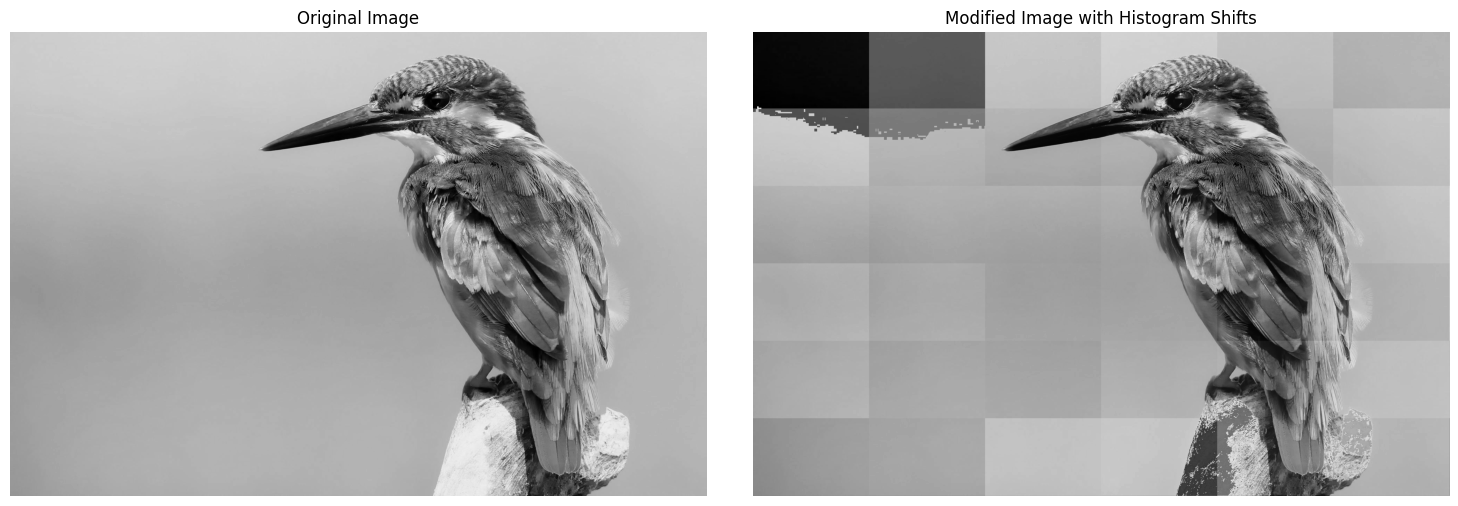

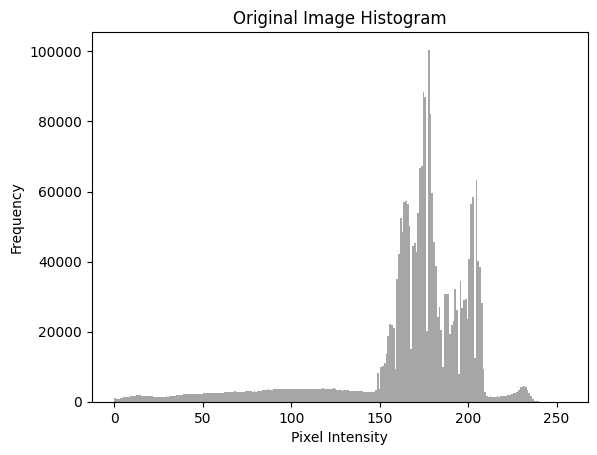

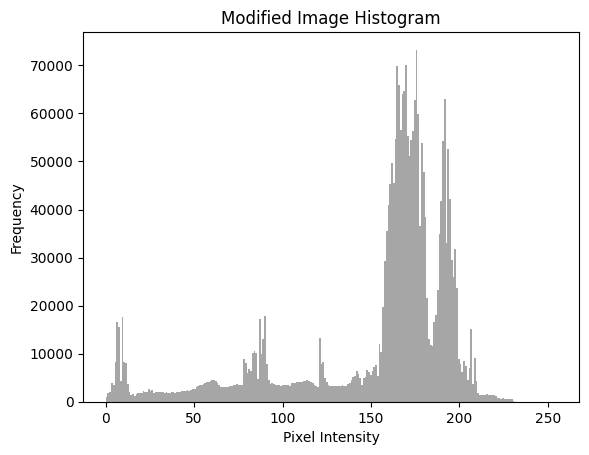

In [43]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(modified_image, cmap='gray')
plt.title('Modified Image with Histogram Shifts')
plt.axis('off')
plt.tight_layout()
plt.show()

# Histograms
plot_histogram(image, "Original Image Histogram")
plot_histogram(modified_image, "Modified Image Histogram")
